In [2]:
import kagglehub
#https://www.vision.ee.ethz.ch/datasets_extra/food-101/
# Download latest version
path = kagglehub.dataset_download("dansbecker/food-101")

print("Path to dataset files:", path)

100%|██████████| 9.38G/9.38G [07:15<00:00, 23.1MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/dansbecker/food-101/versions/1


In [7]:
import os

!ls -R /root/.cache/kagglehub/datasets/dansbecker/food-101/versions/1 | head -40

/root/.cache/kagglehub/datasets/dansbecker/food-101/versions/1:
food-101
food-101.zip

/root/.cache/kagglehub/datasets/dansbecker/food-101/versions/1/food-101:
food-101
__MACOSX

/root/.cache/kagglehub/datasets/dansbecker/food-101/versions/1/food-101/food-101:
images
license_agreement.txt
meta
README.txt

/root/.cache/kagglehub/datasets/dansbecker/food-101/versions/1/food-101/food-101/images:
apple_pie
baby_back_ribs
baklava
beef_carpaccio
beef_tartare
beet_salad
beignets
bibimbap
bread_pudding
breakfast_burrito
bruschetta
caesar_salad
cannoli
caprese_salad
carrot_cake
ceviche
cheesecake
cheese_plate
chicken_curry
chicken_quesadilla
chicken_wings
chocolate_cake
chocolate_mousse
churros
clam_chowder


In [8]:
import pathlib

root = pathlib.Path("/root/.cache/kagglehub/datasets/dansbecker/food-101/versions/1/food-101/food-101")
images_dir = root / "images"
meta_dir   = root / "meta"
print("images_dir:", images_dir)
print("meta_dir:", meta_dir)


images_dir: /root/.cache/kagglehub/datasets/dansbecker/food-101/versions/1/food-101/food-101/images
meta_dir: /root/.cache/kagglehub/datasets/dansbecker/food-101/versions/1/food-101/food-101/meta


In [9]:
import tensorflow as tf
from tensorflow import keras

def read_list(p: pathlib.Path):
    with open(p, "r") as f:
        return [ln.strip() for ln in f if ln.strip()]

train_list = read_list(meta_dir / "train.txt")
test_list  = read_list(meta_dir / "test.txt")

class_names = sorted([p.name for p in images_dir.iterdir() if p.is_dir()])
class_to_idx = {c: i for i, c in enumerate(class_names)}

def to_path_and_label(stem: str):
    cls, base = stem.split("/", 1)                 # e.g., "apple_pie/1005649"
    return str(images_dir / cls / f"{base}.jpg"), class_to_idx[cls]

train_pairs = [to_path_and_label(s) for s in train_list]
test_pairs  = [to_path_and_label(s) for s in test_list]

IMG_SIZE   = (224, 224)
BATCH_SIZE = 32
AUTOTUNE   = tf.data.AUTOTUNE
SEED       = 0

def decode_resize(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)  # [0,1]
    img = tf.image.resize(img, IMG_SIZE, antialias=True)
    return img, label

train_paths, train_labels = zip(*train_pairs)
test_paths,  test_labels  = zip(*test_pairs)

train_ds = (tf.data.Dataset
            .from_tensor_slices((list(train_paths), list(train_labels)))
            .shuffle(len(train_pairs), seed=SEED, reshuffle_each_iteration=True)
            .map(decode_resize, num_parallel_calls=AUTOTUNE)
            .batch(BATCH_SIZE)
            .prefetch(AUTOTUNE))

test_ds = (tf.data.Dataset
           .from_tensor_slices((list(test_paths), list(test_labels)))
           .map(decode_resize, num_parallel_calls=AUTOTUNE)
           .batch(BATCH_SIZE)
           .prefetch(AUTOTUNE))

xb, yb = next(iter(train_ds.take(1)))
print("Batch:", xb.shape, xb.dtype, "range≈[", float(tf.reduce_min(xb)), ",", float(tf.reduce_max(xb)), "]")
print("Classes:", len(class_names))


Batch: (32, 224, 224, 3) <dtype: 'float32'> range≈[ 0.0 , 1.0000003576278687 ]
Classes: 101


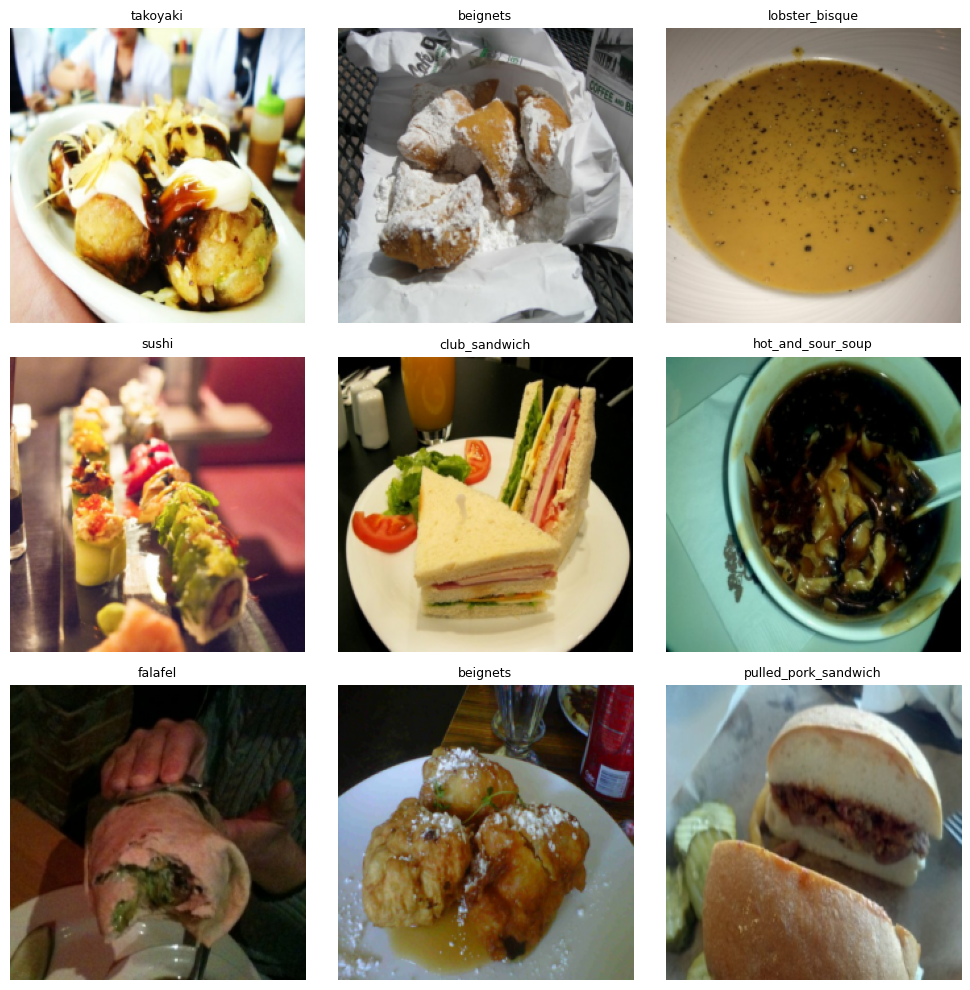

In [10]:
import matplotlib.pyplot as plt

for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy())
        plt.title(class_names[int(labels[i].numpy())], fontsize=9)
        plt.axis("off")
    plt.tight_layout()
    plt.show()
    break
